imports

In [12]:
import random
import socket
import struct


import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

basic networking

In [13]:
def create_socket(host, port):

    my_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

    my_socket.bind((host, port))

    my_socket.listen()

    return my_socket

def waiting_for_connection(ue5socket):
    while True:
        remote_connection , remote_address = ue5socket.accept()
        print(remote_address)
        ue5socket.close()
        break
    return remote_connection,remote_address


environment + connection with the UE5

In [14]:
def sample_action():
    smpl_action = [0, random.uniform(10.0,100.0), random.uniform(-6.0, 6.0), random.uniform(-6.0, 6.0)]
    return smpl_action

class LanderEnv:
    def __init__(self):
        self.state_size = 15
        self.action_size = 3
        self.dq_action_size = 1200*1200*1000
        self.has_landed = 0
        self.observation_space = np.zeros(self.state_size)
        self.action_space = [0, 0, 0]
        self.target_throttle = 60
        self.target_gimbal_pos_x = 0
        self.target_gimbal_pos_y = 0
        self.hasreceivedOver = False
        self.reward = 0
        self.host = "127.0.0.1"
        self.port = 7001
        self.sock = create_socket(self.host, self.port)
        self.packet_size = 1024
        self.PacketCounter = 0
        self.PacketCounter_lastCheck = 0
        self.sock.listen(1)
        print("Waiting for connection...")
        self.conn, self.addr = waiting_for_connection(self.sock)
        self.isDone = False
        self.receive_state()

    def reset(self):
        self.receive_state()
        self.target_throttle = 60
        self.target_gimbal_pos_x = 0
        self.target_gimbal_pos_y = 0
        self.has_landed = 0
        self.isDone = False
        return  self.observation_space

    def receive_state(self):
        received=self.conn.recv(1024)
        if received.__sizeof__() >= 68:
            try:
                rec_data= struct.unpack('17f',received)
                print(rec_data)
                self.isDone = rec_data[0] == 1.0
                self.reward = rec_data[1]
                self.observation_space = rec_data[2:]
            except:
                print("Invalid received size| ",received.__sizeof__())


    def send_action(self):
        print("sending actions: ", [self.target_throttle, self.target_gimbal_pos_x, self.target_gimbal_pos_y])
        self.conn.send(struct.pack('3f',self.target_throttle, self.target_gimbal_pos_x, self.target_gimbal_pos_y))

    def step(self, action):
        self.target_throttle = (action[0]+1.0)*50.0
        self.target_gimbal_pos_x = action[1]*6.0
        self.target_gimbal_pos_y = action[2]*6.0
        self.send_action()
        self.receive_state()
        return self.observation_space, self.reward, self.isDone



the neural network

In [15]:
import torch
from torch import nn #needed for building neural networks
import torch.nn.functional as F #needed for activation functions
import torch.optim as opt #needed for optimisation
from tqdm import tqdm_notebook as tqdm
import random
from copy import copy, deepcopy
from collections import deque
import numpy as np

In [16]:
BUFFER_SIZE=1000000
BATCH_SIZE=64
GAMMA=0.99
TAU=0.001       #Target Network HyperParameters Update rate
LRA=0.0001      #LEARNING RATE ACTOR
LRC=0.001       #LEARNING RATE CRITIC
H1=400   #neurons of 1st layers
H2=300   #neurons of 2nd layers

MAX_EPISODES=50000 #number of episodes of the training
MAX_STEPS=288000    #max steps to finish an episode. An episode breaks early if some break conditions are met
buffer_start = 50 #initial warmup without training
epsilon = 1
epsilon_decay = 1./100000
PRINT_EVERY = 10 #Print info about average reward every PRINT_EVERY

In [17]:
class replayBuffer(object):
    def __init__(self, buffer_size, name_buffer=''):
        self.buffer_size=buffer_size  #choose buffer size
        self.num_exp=0
        self.buffer=deque()

    def add(self, s, a, r, t, s2):
        experience=(s, a, r, t, s2)
        if self.num_exp < self.buffer_size:
            self.buffer.append(experience)
            self.num_exp +=1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.buffer_size

    def count(self):
        return self.num_exp

    def sample(self, batch_size):
        if self.num_exp < batch_size:
            batch=random.sample(self.buffer, self.num_exp)
        else:
            batch=random.sample(self.buffer, batch_size)

        s, a, r, t, s2 = map(np.stack, zip(*batch))

        return s, a, r, t, s2

    def clear(self):
        self.buffer = deque()
        self.num_exp=0

#set GPU for faster training
cuda = torch.cuda.is_available() #check for CUDA
device   = torch.device("cuda" if cuda else "cpu")
print("Job will run on {}".format(device))

Job will run on cpu


In [18]:
def fanin_(size):
    fan_in = size[0]
    weight = 1./np.sqrt(fan_in)
    return torch.Tensor(size).uniform_(-weight, weight)

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, h1=H1, h2=H2, init_w=3e-3):
        super(Critic, self).__init__()

        self.linear1 = nn.Linear(state_dim, h1)
        self.linear1.weight.data = fanin_(self.linear1.weight.data.size())

        #self.bn1 = nn.BatchNorm1d(h1)

        self.linear2 = nn.Linear(h1+action_dim, h2)
        self.linear2.weight.data = fanin_(self.linear2.weight.data.size())

        self.linear3 = nn.Linear(h2, 1)
        self.linear3.weight.data.uniform_(-init_w, init_w)

        self.relu = nn.ReLU()

    def forward(self, state, action):
        x = self.linear1(state)
        x = self.relu(x)
        x = self.linear2(torch.cat([x,action],1))

        x = self.relu(x)
        x = self.linear3(x)

        return x


class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, h1=H1, h2=H2, init_w=0.003):
        super(Actor, self).__init__()

        #self.bn0 = nn.BatchNorm1d(state_dim)

        self.linear1 = nn.Linear(state_dim, h1)
        self.linear1.weight.data = fanin_(self.linear1.weight.data.size())

        #self.bn1 = nn.BatchNorm1d(h1)

        self.linear2 = nn.Linear(h1, h2)
        self.linear2.weight.data = fanin_(self.linear2.weight.data.size())

        #self.bn2 = nn.BatchNorm1d(h2)

        self.linear3 = nn.Linear(h2, action_dim)
        self.linear3.weight.data.uniform_(-init_w, init_w)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, state):
        #state = self.bn0(state)
        x = self.linear1(state)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.tanh(x)
        return x

    def get_action(self, state):
        state  = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.forward(state)
        return action.detach().cpu().numpy()[0]

In [19]:
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu=0, sigma=0.2, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [20]:
env = LanderEnv()

state_dim = 15
action_dim = 3

print("State dim: {}, Action dim: {}".format(state_dim, action_dim))

noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

critic  = Critic(state_dim, action_dim).to(device)
actor = Actor(state_dim, action_dim).to(device)

target_critic  = Critic(state_dim, action_dim).to(device)
target_actor = Actor(state_dim, action_dim).to(device)

for target_param, param in zip(target_critic.parameters(), critic.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_actor.parameters(), actor.parameters()):
    target_param.data.copy_(param.data)

q_optimizer  = opt.Adam(critic.parameters(),  lr=LRC)#, weight_decay=0.01)
policy_optimizer = opt.Adam(actor.parameters(), lr=LRA)

MSE = nn.MSELoss()

memory = replayBuffer(BUFFER_SIZE)

Waiting for connection...
('127.0.0.1', 53281)
(0.0, -601480.875, 3074.43896484375, 0.005295308772474527, 0.003090767888352275, -0.7102090716362, 3145.0, 2.9291129112243652, -1.6366217136383057, 40.0, 60.0, 0.0, 0.0, 0.0, 0.0, 8200.0, 600.0)
State dim: 15, Action dim: 3


In [21]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
%matplotlib inline

def subplot(R, P, Q, S):
    r = list(zip(*R))
    p = list(zip(*P))
    q = list(zip(*Q))
    s = list(zip(*S))
    clear_output(wait=True)

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

    ax[0, 0].plot(list(r[1]), list(r[0]), 'r') #row=0, col=0
    ax[1, 0].plot(list(p[1]), list(p[0]), 'b') #row=1, col=0
    ax[0, 1].plot(list(q[1]), list(q[0]), 'g') #row=0, col=1
    ax[1, 1].plot(list(s[1]), list(s[0]), 'k') #row=1, col=1
    ax[0, 0].title.set_text('Reward')
    ax[1, 0].title.set_text('Policy loss')
    ax[0, 1].title.set_text('Q loss')
    ax[1, 1].title.set_text('Max steps')
    plt.show()

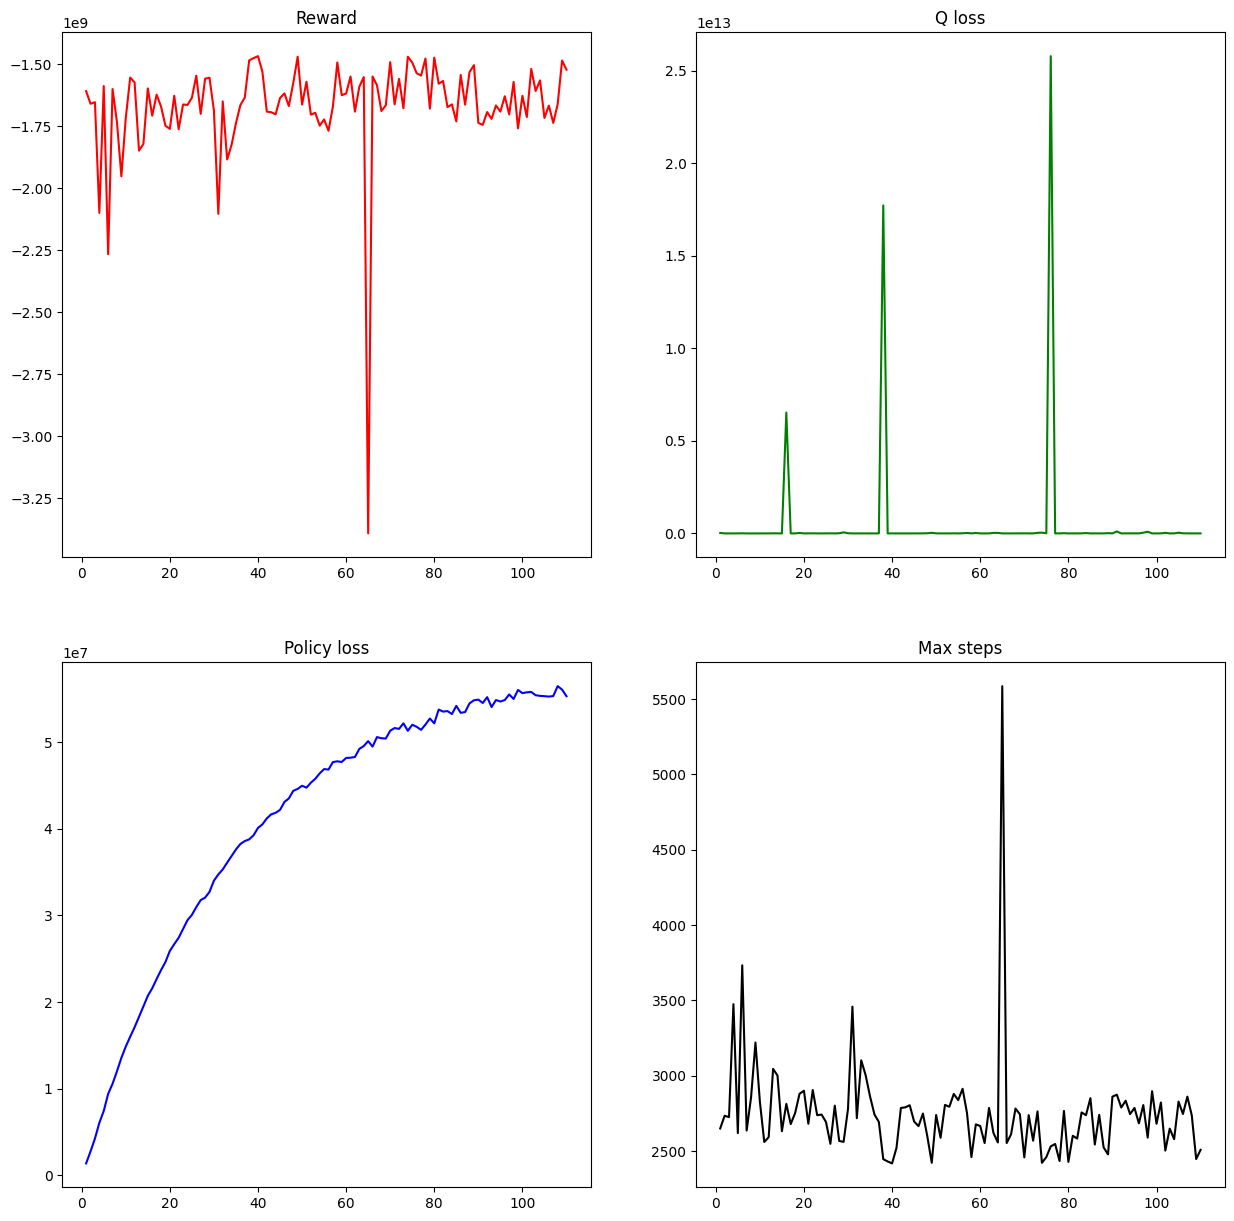

[   110 episode,   302305 total steps] average reward for past 10 iterations: -1620249995.899
Last model saved with reward: -1468374386.98, at episode 40.
Episode: 110
Invalid received size|  169
Etap: 110, Step: 0
sending actions:  [0.0, 6.0, -6.0]
(0.0, -607500.875, 3834.23193359375, 0.005295308772474527, 0.003090767888352275, -1.5712709426879883, 3845.0, 3.1415927410125732, 0.21692101657390594, 0.0, 0.0, 0.13924171030521393, -0.13924171030521393, 6.0, -6.0, 8199.873046875, 599.7213134765625)
Etap: 110, Step: 1
sending actions:  [0.0, 6.0, -6.0]
(0.0, -607500.9375, 3834.220458984375, 0.005295308772474527, 0.003090767888352275, -1.5712709426879883, 3845.0, 3.1415927410125732, 0.21692097187042236, 0.0, 0.0, 0.1515384167432785, -0.1515384167432785, 6.0, -6.0, 8199.873046875, 599.6967163085938)
Etap: 110, Step: 2
sending actions:  [0.0, 6.0, -6.0]
(0.0, -607500.9375, 3834.2080078125, 0.005295308772474527, 0.003090767888352275, -1.5712709426879883, 3845.0, 3.1415927410125732, 0.2169209122

In [ ]:
plot_reward = []
plot_policy = []
plot_q = []
plot_steps = []


best_reward = -np.inf
saved_reward = -np.inf
saved_ep = 0
average_reward = 0
global_step = 0

#s = deepcopy(env.reset())

for episode in range(MAX_EPISODES):
    print(f"Episode: {episode}")
    s = env.reset()
    #noise.reset()

    ep_reward = 0.
    ep_q_value = 0.
    step=0
    terminal = False

    while not terminal:
        #loss=0
        global_step +=1
        epsilon -= epsilon_decay
        actor.eval()
        a = actor.get_action(s)
        actor.train()
        print(f"Etap: {episode}, Step: {step}")
        a += noise()*max(0, epsilon)
        a = np.clip(a, -1., 1.)
        s2, reward, terminal = env.step(a)


        memory.add(s, a, reward, terminal,s2)

        #keep adding experiences to the memory until there are at least minibatch size samples

        if memory.count() > buffer_start:
            s_batch, a_batch, r_batch, t_batch, s2_batch = memory.sample(BATCH_SIZE)

            s_batch = torch.FloatTensor(s_batch).to(device)
            a_batch = torch.FloatTensor(a_batch).to(device)
            r_batch = torch.FloatTensor(r_batch).unsqueeze(1).to(device)
            t_batch = torch.FloatTensor(np.float32(t_batch)).unsqueeze(1).to(device)
            s2_batch = torch.FloatTensor(s2_batch).to(device)


            #compute loss for critic
            a2_batch = target_actor(s2_batch)
            target_q = target_critic(s2_batch, a2_batch) #detach to avoid updating target
            y = r_batch + (1.0 - t_batch) * GAMMA * target_q.detach()
            q = critic(s_batch, a_batch)

            q_optimizer.zero_grad()
            q_loss = MSE(q, y) #detach to avoid updating target
            q_loss.backward()
            q_optimizer.step()

            #compute loss for actor
            policy_optimizer.zero_grad()
            policy_loss = -critic(s_batch, actor(s_batch))
            policy_loss = policy_loss.mean()
            policy_loss.backward()
            policy_optimizer.step()

            #soft update of the frozen target networks
            for target_param, param in zip(target_critic.parameters(), critic.parameters()):
                target_param.data.copy_(
                    target_param.data * (1.0 - TAU) + param.data * TAU
                )

            for target_param, param in zip(target_actor.parameters(), actor.parameters()):
                target_param.data.copy_(
                    target_param.data * (1.0 - TAU) + param.data * TAU
                )

        s = deepcopy(s2)
        ep_reward += reward
        step += 1


    try:
        plot_reward.append([ep_reward, episode+1])
        plot_policy.append([policy_loss.data, episode+1])
        plot_q.append([q_loss.data, episode+1])
        plot_steps.append([step+1, episode+1])
    except:
        continue
    average_reward += ep_reward

    if ep_reward > best_reward:
        torch.save(actor.state_dict(), 'best_model_lander.pkl') #Save the actor model for future testing
        best_reward = ep_reward
        saved_reward = ep_reward
        saved_ep = episode+1

    if (episode % PRINT_EVERY) == (PRINT_EVERY-1):    # print every print_every episodes
        subplot(plot_reward, plot_policy, plot_q, plot_steps)
        print('[%6d episode, %8d total steps] average reward for past {} iterations: %.3f'.format(PRINT_EVERY) %
              (episode + 1, global_step, average_reward / PRINT_EVERY))
        print("Last model saved with reward: {:.2f}, at episode {}.".format(saved_reward, saved_ep))
        average_reward = 0 #reset average reward
